In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

New simulations to add:

- Reconstruct a signal with the wavelet packet and show the reconstruction error. Do it for different wavelet decompositions and compare. We shouldnt see big differences in the reconstruction error. However, we should perceive that the signal is better "qualitatively" (by looking at the temporal representation, for instanc). With images we should see a better result.

- Compute the autocorrelation function of wavelets coefficients for the same resolution level but for different filter combinations (different paths in the decomposition tree). We should see that the wavelet coefficients at the begining and at the end of the band are really decorrelated, but those in the middle are not. The beginnig and the end of the band are the combination paths that only combine low pass and high pass filters, respectively.

- Stochastic Integral

## Random process definition

In [115]:
def ar_process(N, alpha):
    
    X = []
    X_actual = 0
    for i in range(1,N):
        X_plus = alpha * X_actual + np.random.randn() 
        X.append(X_plus)
        X_actual = X_plus
        
    return X

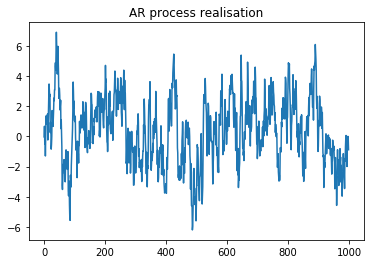

In [116]:
N = 1000
alpha = 0.9
X = []
X_actual = 0
for i in range(1,N):
    X_plus = alpha * X_actual + np.random.randn() 
    X.append(X_plus)
    X_actual = X_plus

plt.plot(X)
plt.title("AR process realisation")
plt.show()

## Autocorrelation function and PSD

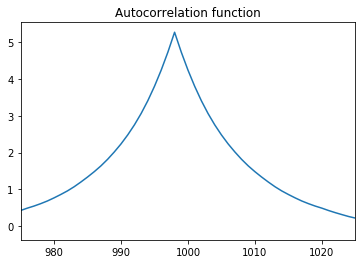

In [124]:
N = 1000
alpha = 0.9
Nrealisations = 100
R = np.zeros(2*N-3)

for j in range(Nrealisations):
    X = []
    X_actual = 0
    for i in range(1,N):
        X_plus = alpha * X_actual + np.random.randn() 
        X.append(X_plus)
        X_actual = X_plus
    R += np.correlate(X,X, mode='full')    
        
R = R/Nrealisations

var = 1/(1-alpha**2)

plt.plot(R/max(R)*var)
plt.xlim([1000-25,1000+25])
plt.title("Autocorrelation function")
plt.show()

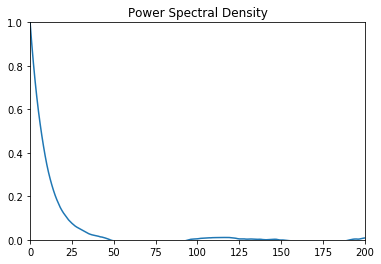

In [121]:
psd = np.fft.fftshift(R)
plt.plot(psd/psd[0])
plt.xlim([0,200])
plt.ylim([0,1])
plt.title("Power Spectral Density")
plt.show()

 ## Multi-level wavelet packet decomposition

We perform a multi-level wavelet packet decomposition of resolution level up to 3 of an AR process of $\alpha=1$ and we plot its approximation ($W_{3,0}$) and detail ($W_{3,1}$, $W_{2,1}$, $W_{1,1}$) coefficients. We chose $\alpha=1$ for having a slower and more correlated process, wich allows us to better see the differences between the approximation (lower frequencies) and the detail (higher frequencies) coefficients. We note that if $\alpha$ is bigger than one, the process is unstable.

In all these simulations, the Daubechies filters were used.

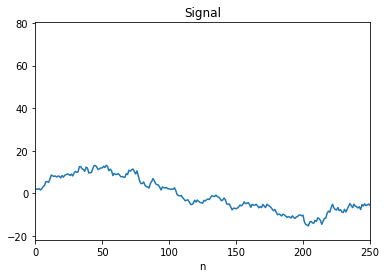

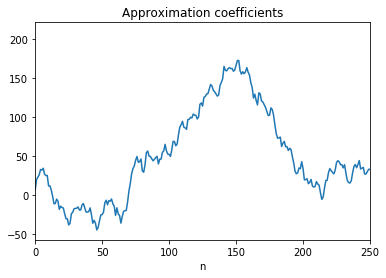

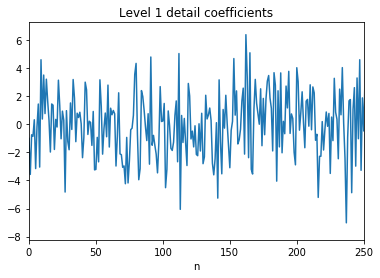

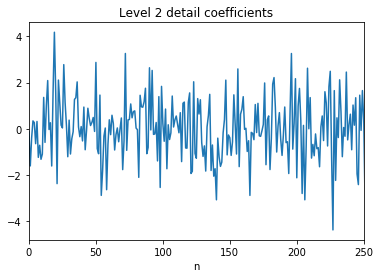

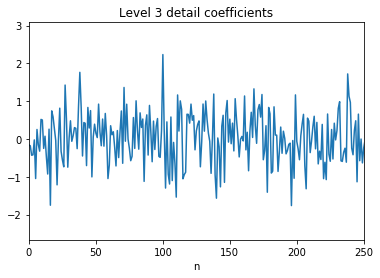

In [95]:
# AR process
alpha = 1
N = 4000
Nrealisations = 100
Rlist = []

X = ar_process(N, alpha)

plt.plot(X)
plt.xlabel('n')
plt.xlim([0,250])
plt.title('Signal')
plt.show()

coefs = pywt.wavedec(X, 'db1', level = 3)

for c,i in zip(coefs,range(len(coefs))):
    
    plt.plot(c)
    plt.xlabel('n')
    plt.xlim([0,250])
    
    if i==0:
        plt.title('Approximation coefficients')
    else:
        plt.title('Level '+str(i)+' detail coefficients')
    
    plt.show()

For $\alpha=0.9$, we estimate the autocorrelation functions of the wavelet coefficients by using the Montecarlo method. We can see that the coefficients related to the higher frequencies are more deocorrelated, as they represent the white noise part of the stochastic process. 

In [97]:
wavelet_decomposition_coeff_name = ['W3,0 decomposition', 'W3,1  decomposition', 
                                    'W2,1 decomposition','W1,1  decomposition']
autocorrelation_names = ['R3,0','R3,1','R2,1','R1,1']

In [98]:
# AR process
alpha = 0.9
N = 4000
Nrealisations = 100
Rlist = []

X = ar_process(N, alpha)

coefs = pywt.wavedec(X, 'db1', level = 3)

for c in coefs:
    Rlist.append(np.correlate(c,c, mode='full')/Nrealisations)

for j in range(Nrealisations-1):

    X = ar_process(N, alpha)
    
    coefs = pywt.wavedec(X, 'db1', level = 3)
    
    for c,i in zip(coefs,range(len(coefs))):
                
        Rlist[i] = Rlist[i] + np.correlate(c,c, mode='full')/Nrealisations

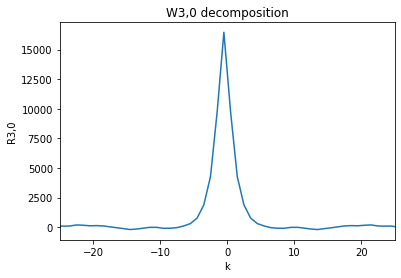

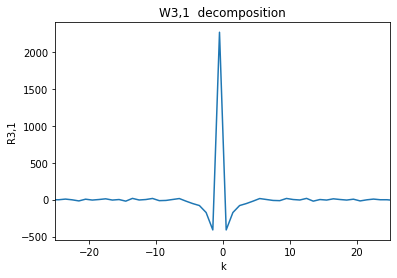

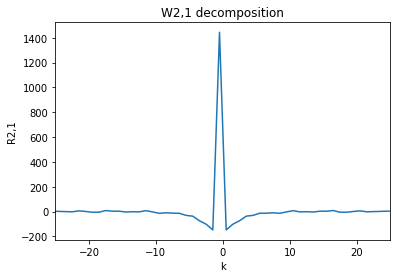

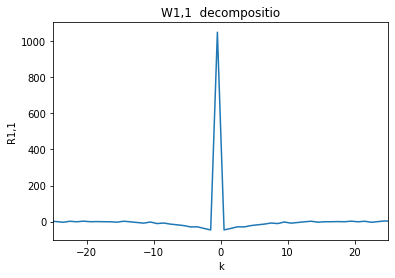

In [77]:
for R, coeff_name,aucorr_name in zip(Rlist,wavelet_decomposition_coeff_name,autocorrelation_names):

    t_axis = range(0, len(R))
    t_axis = t_axis - len(R)/2 * np.ones(len(t_axis))
    
    plt.plot(t_axis,R)
    plt.title(coeff_name)
    plt.xlabel('k')
    plt.ylabel(aucorr_name)
    plt.xlim([-25,25])
    plt.show()

## Decorrelation with respect to the resolution level

We now vary the resolution level of the wavelet packet decomposition and we plot the estimated autocorrelation functions of the approximation coefficients (always using the Montecarlo method). We measure the level of decorrelation by calculating the euclidean distance from each autocorrelation function to a Dirac's delta function. We obtain, as demonstrated in the article, that the coefficients are more decorrelated when the resolution level increases.

Distance to white noise for level 1: 1988.023114953924


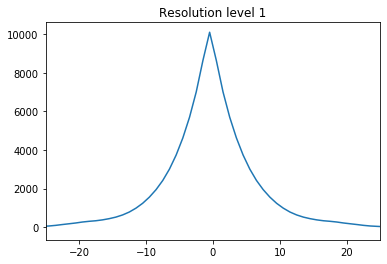

Distance to white noise for level 2: 1064.7353823266424


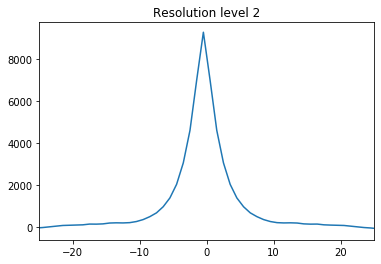

Distance to white noise for level 3: 536.188675358258


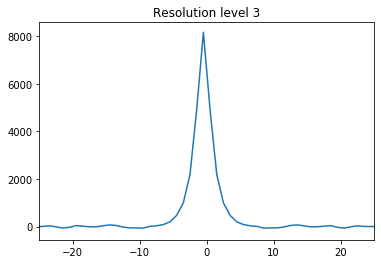

Distance to white noise for level 4: 286.82164510794496


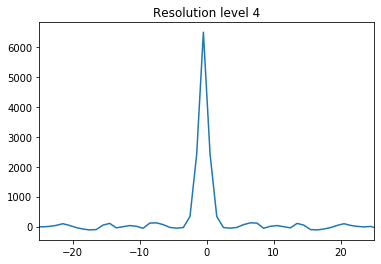

Distance to white noise for level 5: 178.72499578358847


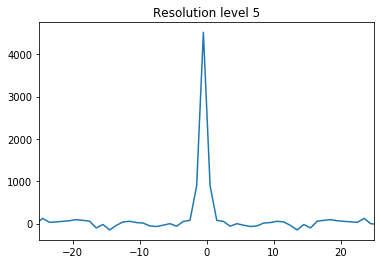

Distance to white noise for level 6: 89.80611690586503


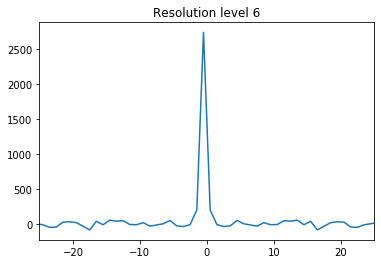

In [128]:
maxLevel = 7
Nrealisations = 100
N = 2000
alpha = 0.9
delta = 25

for level in range(1,maxLevel):
    
    # AR process
    
    X = ar_process(N, alpha)
    
    coefs = pywt.downcoef('a',X, 'db1', level = level)
    
    R = np.correlate(coefs,coefs, mode='full')/Nrealisations
        
    for j in range(Nrealisations-1):
        
        X = ar_process(N, alpha)
        
        coefs = pywt.downcoef('a',X, 'db1', level = level)
                
        R += np.correlate(coefs,coefs, mode='full')/Nrealisations
                
    
    # white noise

    Nwn = len(coefs)
    R_white_noise = np.zeros(2*Nwn-1)

    for j in range(Nrealisations):

        X = np.random.randn(Nwn)

        R_white_noise += np.correlate(X,X, mode='full')/Nrealisations

    distance = np.mean(abs(R_white_noise[int(len(R)/2)-delta:int(len(R)/2)+delta]-R[int(len(R)/2)-delta:int(len(R)/2)+delta]))
    
    print("Distance to white noise for level "+str(level)+": "+str(distance))
    
    ## plot
    
    t_axis = range(0, len(R))
    t_axis = t_axis - len(R)/2 * np.ones(len(t_axis))


    plt.figure()
    plt.plot(t_axis,R)
    plt.title("Resolution level "+str(level))
    plt.xlim([-25,25])
    plt.show()

In [106]:
maxLevel = 15
Nrealisations = 100
N = 50000
alpha = 0.9
delta = 25

distances = []

for level in range(0,maxLevel):
    
    # AR process
    
    X = ar_process(N, alpha)
    
    coefs = pywt.wavedec(X, 'db1', level = level)
    
    R = np.correlate(coefs[0],coefs[0], mode='full')/Nrealisations
    
    for j in range(Nrealisations):
        
        X = ar_process(N, alpha)

        coefs = pywt.wavedec(X, 'db1', level = level)
                
        R += np.correlate(coefs[0],coefs[0], mode='full')/Nrealisations
    
    
    # white noise

    Nwn = len(coefs[0])
    R_white_noise = np.zeros(2*Nwn-1)

    for j in range(Nrealisations-1):

        X = np.random.randn(Nwn)

        R_white_noise += np.correlate(X,X, mode='full')/Nrealisations

    distance = np.mean(abs(R_white_noise[int(len(R)/2)-delta:int(len(R)/2)+delta]-R[int(len(R)/2)-delta:int(len(R)/2)+delta]))
    distances.append(distance)

We then plot the "decorrelation coefficient" (defined as the distance to a Dirac delta function) as a function of the resolution level. We have normalized these coefficients for better visualization.

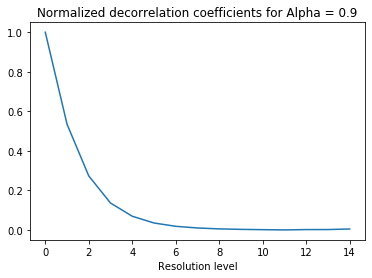

In [110]:
plt.plot(distances/max(distances))
plt.xlabel('Resolution level')
plt.title('Normalized decorrelation coefficients for Alpha = 0.9')
plt.show()

## Decorrelation with respect to the resolution level for differentes alphas

We repeat the previous simulation for different values of $\alpha$ and we plot the non-normalized decorrelation coefficient (the fact of no normalizing it allows us to compare the results for different Alphas). We obtain, as expected, that the coefficients are more decorrelated as $\alpha$ gets smaller. This is due to the fact that the input process X gets more similar to a white gaussian process (and, as a consequence, it gets less correlated) as this coefficients get smaller.

In [130]:
maxLevel = 10
Nrealisations = 100
N = 5000
alphas = [0.2,0.4,0.6,0.9]
delta = 25
index = 0

distances_alpha = []

for alpha in alphas:

    distances = []

    for level in range(0,maxLevel):

        # AR process

        X = ar_process(N, alpha)

        coefs = pywt.wavedec(X, 'db1', level = level)

        R = np.correlate(coefs[0],coefs[0], mode='full')

        for j in range(Nrealisations):

            X = ar_process(N, alpha)

            coefs = pywt.wavedec(X, 'db1', level = level)

            R += np.correlate(coefs[0],coefs[0], mode='full')

        R = R/Nrealisations


        # white noise

        Nwn = len(coefs[0])
        R_white_noise = np.zeros(2*Nwn-1)

        for j in range(Nrealisations):

            X = np.random.randn(Nwn)

            R_white_noise += np.correlate(X,X, mode='full')

        R_white_noise = R_white_noise/Nrealisations

        distance = np.mean(abs(R_white_noise[int(len(R)/2)-delta:int(len(R)/2)+delta]-R[int(len(R)/2)-delta:int(len(R)/2)+delta]))
        distances.append(distance)
    distances_alpha.append(distances)
    index += 1

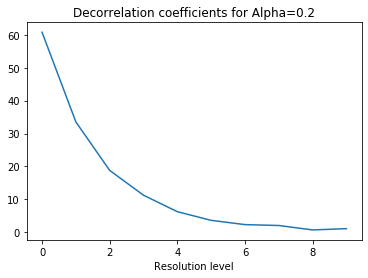

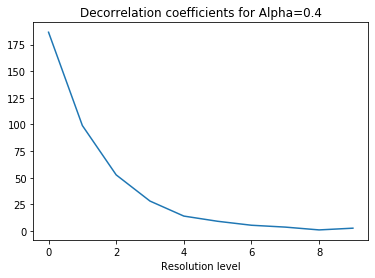

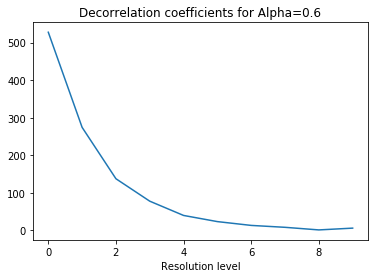

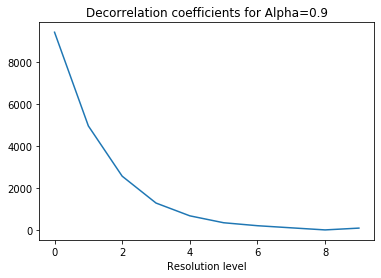

In [131]:
for i in range(len(alphas)):

    plt.plot(distances_alpha[i])
    plt.title("Alpha="+str(alphas[i]))
    plt.xlabel('Resolution level')
    plt.title('Decorrelation coefficients for Alpha='+str(alphas[i]))
    plt.show()